In [2]:
import numpy as np 
import matplotlib.pyplot as plt

# Torch
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

# Save/Load as mat.
from scipy.io import savemat, loadmat
import h5py
import mat73 # https://github.com/skjerns/mat7.3

# Progress Bar
from rich.progress import track
from rich.progress import Progress

# Other
import argparse
import multiprocessing as mp
import os
import scipy.signal as signal
import time

# User-defined
from mat2np_segment_all_subject import *
from dsp_preprocess import *
from dataset_parser import *
from models import *
from feature_extractor import *
from set_args import *
from train_test_process import *
from vit import *

### Parameter setup

In [3]:
set_seed(87)

raw_args = [
    '--subject_list=1',
    # '--exercise_list=1,2,3',
    '--window_size_sec=0.2',
    '--window_step_sec=0.1',
    # '--type_filter=BPF_20_200'
    # '--type_norm=mvc'
    '--num_epoch=20',
    '--batch_size=512',
    '--model_type=ViT',
    '--lr=0.001',
    '--en_train',
    '--load_dataset'
    # '--save_dataset'
]

args = get_args(raw_args)
window_size, window_step, number_gesture, model_PATH, device = get_args_info(args)

for key, value in vars(args).items():
    print(f"{key} = {value}")
    exec("{} = args.{}".format(key,key))
    




----------------------------------------------------------------------
Database: NinaPro  DB2
Number of subjects:  1  -> [1] subject
Number of  exercises:  3  -> [1, 2, 3] exercise
Number of gestures:  49, and we excludes 'rest' class
----------------------------------------------------------------------
Sampling rate:  2000  (sps)
Number of channels:  12
Window size:  400  (samples) =  200.0  (ms)
Window step:  200  (samples) =  100.0  (ms)
----------------------------------------------------------------------
Device:  cuda:0
Feature extraction:  False
Model type:  ViT
Model PATH:  ./Results/Lastest_results/ViT.pth
Load model:  True
Number of epochs:  20
Batch size:  512
Learning rate:  0.001
----------------------------------------------------------------------

subject_list = [1]
exercise_list = [1, 2, 3]
fs = 2000
num_channel = 12
window_size_sec = 0.2
window_step_sec = 0.1
type_filter = none
type_norm = mvc
num_epoch = 20
batch_size = 512
lr = 0.001
database = DB2
model_type = Vi

### Dataset setup

In [172]:
train_loader, valid_loader, test_loader = train_test_split_DataLoader(\
                                            batch_size=batch_size, \
                                            subject_list=subject_list, \
                                            exercise_list=exercise_list, \
                                            fs=fs, \
                                            window_size=window_size, \
                                            window_step=window_step, \
                                            num_channel=num_channel, \
                                            feat_extract=feat_extract, \
                                            class_rest=class_rest, \
                                            load_dataset = load_dataset, \
                                            save_dataset = save_dataset
                                        )


----------------------------------------------------------------------
Loading saved train dataset in ./Dataset/DB2/
Loading saved valid dataset in ./Dataset/DB2/
Loading saved test dataset in ./Dataset/DB2/
----------------------------------------------------------------------
Number of train data: 254869
Number of valid data: 81360
Number of test  data: 167941
----------------------------------------------------------------------



In [173]:
def train_process(args,model,model_PATH,train_loader,valid_loader,device,optimizer,criterion):
    # Print the model summary
    summary(model, (train_loader.dataset[0][0].shape))
    
    # model.load_state_dict(torch.load(model_PATH)) # Pretrained model

    t_start = time.time()
    # with Progress(console=Console(file=sys.stderr)) as progress:
    #with Progress() as progress:
    # task1 = progress.add_task("[cyan]Epoch: ", total=args.num_epoch)

    loss_best = float("inf")
    not_better_count = 0    
    # print('', end='', flush=True)
    for epoch in range(args.num_epoch):
        end_type = '\n' if epoch==args.num_epoch-1 else '\r'
        # end_type = '\n'
        
        # Training Stage
        model.train() # Make sure the model is in train mode before training.
        # task2 = progress.add_task("[green][Train: ]", total=len(train_loader))
        running_loss_train = 0.0
        running_acc_train = 0.0
        n_train = 0
        for i, (emg_sample, gesture_gold) in enumerate(train_loader):
            emg_sample = emg_sample.to(device) # input
            gesture_gold = gesture_gold.to(device) # Output

            if args.model_type == "ViT":
                # emg_sample = torch.unsqueeze(emg_sample.permute(0,2,1), dim=3)  # shape: (B, C, W, F) = (128, 12, 400, 1)
                emg_sample = emg_sample.permute(0,2,1)  # shape: (B, C, 1*W*F) 

            gesture_pred = model(emg_sample)
            
            optimizer.zero_grad()
            loss = criterion(gesture_pred,gesture_gold)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.detach().item()*emg_sample.shape[0]
            num_correct = (torch.argmax(gesture_pred, dim=1)==gesture_gold).sum()
            running_acc_train += num_correct
            n_train += emg_sample.shape[0]
            # progress.update(task2, advance=1,description="[green][Train: %3d] [Train loss: %3.3f] [Train acc: %3.2f %%]: " % (i+1,running_loss_train/n_train, 100*running_acc_train/n_train))
            
        # print("[Train: %3d] [Train loss: %3.3f] [Train acc: %3.2f %%]: " % (i+1,running_loss_train/n_train, 100*running_acc_train/n_train), end=end_type)
        # progress.remove_task(task2)

        # Validation Stage
        model.eval() # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        # task3 = progress.add_task("[red]Validate ", total=len(valid_loader))
        running_loss_valid = 0.0
        running_acc_valid = 0.0
        n_valid = 0
        with torch.no_grad():
            for i, (emg_sample, gesture_gold) in enumerate(valid_loader):
                emg_sample = emg_sample.to(device) # input

                if args.model_type == "ViT":
                    # emg_sample = torch.unsqueeze(emg_sample.permute(0,2,1), dim=3)  # shape: (B, C, W, F) = (128, 12, 400, 1)
                    emg_sample = emg_sample.permute(0,2,1)  # shape: (B, C, 1*W*F)

                gesture_gold = gesture_gold.to(device) # Output
                gesture_pred = model(emg_sample)

                loss = criterion(gesture_pred,gesture_gold)

                running_loss_valid += loss.detach().item()*emg_sample.shape[0]
                num_correct = (torch.argmax(gesture_pred, dim=1)==gesture_gold).sum() # torch.mean((torch.argmax(gesture_pred, dim=1) == labels).float()
                

                running_acc_valid += num_correct
                n_valid += emg_sample.shape[0]
                # progress.update(task3, advance=1,description="[red][Validate: %3d] [Valid loss: %3.3f] [Valid acc: %3.2f %%]: " % (i+1, running_loss_valid/n_valid, 100*running_acc_valid/n_valid))
            # print("[Valid: %3d] [Valid loss: %3.3f] [Valid acc: %3.2f %%]: " % (i+1, running_loss_valid/n_valid, 100*running_acc_valid/n_valid),  end=end_type)
        # progress.remove_task(task3)
        
        # Finishing a epoch
        # progress.update(task1, advance=1,description="[cyan][Epoch: %3d] [Train loss: %3.3f acc: %3.2f %%] [Valid loss: %3.3f acc: %3.2f %%]" 
        #                 %(epoch+1, running_loss_train/n_train, 100*running_acc_train/n_train, running_loss_valid/n_valid, 100*running_acc_valid/n_valid))
        print("[Epoch: %3d / %d] [Train loss: %3.3f acc: %4.2f] [Valid loss: %3.3f acc: %4.2f]" 
                        %(epoch+1, args.num_epoch, running_loss_train/n_train, 100*running_acc_train/n_train, running_loss_valid/n_valid, 100*running_acc_valid/n_valid),  end=end_type, flush=True)

        print(model.layers[10].weight)
        
        # Save model or not 
        if running_loss_valid < loss_best:
            loss_best = running_loss_valid
            # print("New best loss in valid => Saving the model @ %s", PATH)
            torch.save(model.state_dict(), model_PATH)
            not_better_count = 0
        else:
            not_better_count = not_better_count+1
        if not_better_count > 10 and epoch>30:
            break
    
    t_end = time.time()
    print("Elasped training time: ", t_end - t_start)  

In [174]:
# Training Setup
if args.model_type == "ViT":
    # TNet
    num_patch = args.num_channel
    patch_size = window_size
    model = ViT(num_patch,patch_size).to(device)
else:
    model = eval(f"{args.model_type}(number_gesture=number_gesture, class_rest=args.class_rest)").to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00) 
criterion = nn.CrossEntropyLoss()

# Model Training and Validation
if args.en_train:
    train_process(args,model,model_PATH,train_loader,valid_loader,device,optimizer,criterion)

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: []

In [ ]:
def test_process(model,model_PATH,test_loader,device,criterion,load_model,model_type):
    if load_model == True:
        print("Loading the trained model on th path of: ",model_PATH)
        model.load_state_dict(torch.load(model_PATH))
        

    # with Progress() as progress:
    # Testing Stage
    model.eval() # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    # task4 = progress.add_task("[blue]Batch ", total=len(test_loader))
    running_loss_test = 0.0
    running_acc_test = 0.0
    n_test = 0

    y_pred = []
    y_gold = []

    with torch.no_grad():
        for i, (emg_sample, gesture_gold) in enumerate(test_loader):
            emg_sample = emg_sample.to(device) # input
            gesture_gold = gesture_gold.to(device) # Output

            if model_type == "ViT":
                # emg_sample = torch.unsqueeze(emg_sample.permute(0,2,1), dim=3)  # shape: (B, C, W, F) = (128, 12, 400, 1)
                emg_sample = emg_sample.permute(0,2,1)  # shape: (B, C, 1*W*F)
            gesture_pred = model(emg_sample)

            y_pred.extend(gesture_pred.argmax(dim=-1).view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
            y_gold.extend(gesture_gold.view(-1).detach().cpu().numpy())      # target是ground-truth的labe
            
            loss = criterion(gesture_pred,gesture_gold)

            running_loss_test += loss.detach().item()*emg_sample.shape[0]
            num_correct = (torch.argmax(gesture_pred, dim=1)==gesture_gold).sum()
            running_acc_test += num_correct
            n_test += emg_sample.shape[0]

            # progress.update(task4, advance=1,description="[blue][Test loss: %3.3f] [Test acc: %3.2f %%]: " % (running_loss_test/n_test, 100*running_acc_test/n_test))
        print("[Test loss: %3.3f] [Test acc: %3.2f %%] " % (running_loss_test/n_test, 100*running_acc_test/n_test), flush=True)

    # Print the model summary
    # summary(model, (emg_sample.shape[1:]))

    return np.array(y_pred), np.array(y_gold) # (num_test,)

In [ ]:
# Model Testing
y_pred, y_gold = test_process(model,model_PATH,test_loader,device,criterion,args.load_model,args.model_type)

Loading the trained model on th path of:  ./Models/CNN_model.pth


[Test loss: 2.486] [Test acc: 32.23 %] 


In [ ]:
# emg_sample, gesture_gold = valid_loader.dataset[0:1000]
# gesture_gold

In [ ]:
# PATH_seg_np = "Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_1/"
# fileNames = [PATH_seg_np+i for i in os.listdir(PATH_seg_np)]
# for fileName in fileNames:
#     print(fileName)
#     emg_sample_filter_norm_seg_batch, gesture_label_batch = dataset_filter_normalize_segementation(fileName)

In [ ]:
model = eval(f"{args.model_type}(number_gesture=number_gesture, class_rest=args.class_rest)").to(device)
# model.load_state_dict(torch.load(model_PATH))
print(model.layers)
print(model.layers[10].weight)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=576, out_features=49, bias=True)
)
Parameter containing:
tensor([[-0.0404, -0.0249,  0.0367,  ...,  0.0387,  0.0014,  0.0178],
        [-0.0411,  0.0054,  0.0306,  ..., -0.0009,  0.0060, -0.0046],
        [-0.0180,  0.0207,  0.0178,  ..., -0.0257,  0.0403, -0.0019],
        ...,
        [-0.0348,  0.0352, -0.0037,  ...,  0.0294,  0.0153,  0.0311],
        [-0.0153,  0.0129,  0.0322,  ..., 

In [ ]:
model.eval() # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
# task4 = progress.add_task("[blue]Batch ", total=len(test_loader))
running_loss_test = 0.0
running_acc_test = 0.0
n_test = 0

y_pred = []
y_gold = []

with torch.no_grad():
    emg_sample, gesture_gold = test_loader.dataset[8000:9000]
    emg_sample = emg_sample.to(device) # input
    gesture_gold = gesture_gold.to(device) # Output
    # print(emg_sample)
    
    # print(gesture_gold)

    if model_type == "ViT":
        # emg_sample = torch.unsqueeze(emg_sample.permute(0,2,1), dim=3)  # shape: (B, C, W, F) = (128, 12, 400, 1)
        emg_sample = emg_sample.permute(0,2,1)  # shape: (B, C, 1*W*F)
    gesture_pred = model(emg_sample)
    # print(gesture_pred)

    y_pred.extend(gesture_pred.argmax(dim=-1).view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
    y_gold.extend(gesture_gold.view(-1).detach().cpu().numpy())      # target是ground-truth的labe
    
    loss = criterion(gesture_pred,gesture_gold)

    running_loss_test += loss.detach().item()*emg_sample.shape[0]
    num_correct = (torch.argmax(gesture_pred, dim=1)==gesture_gold).sum()
    running_acc_test += num_correct
    n_test += emg_sample.shape[0]

        # progress.update(task4, advance=1,description="[blue][Test loss: %3.3f] [Test acc: %3.2f %%]: " % (running_loss_test/n_test, 100*running_acc_test/n_test))
    print("[Test loss: %3.3f] [Test acc: %3.2f %%] " % (running_loss_test/n_test, 100*running_acc_test/n_test), flush=True)

ZeroDivisionError: float division by zero

Text(0.5, 1.0, 'Confusion Matrix')

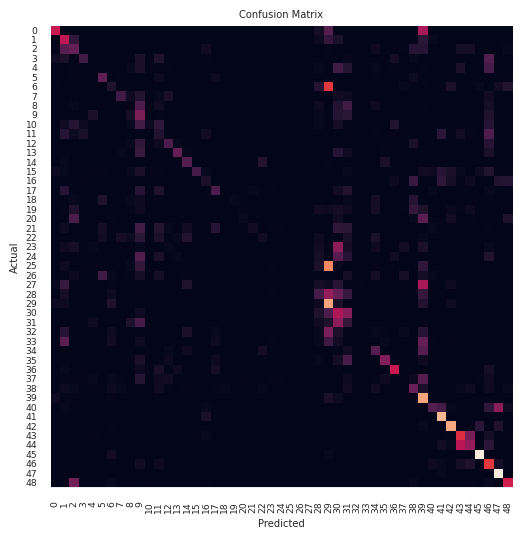

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_gold, y_pred)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(6, 6))
sns.set(font_scale=0.6)
sns.heatmap(cm, annot=False, fmt='d', cbar=False, square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')